In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [8]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [9]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [10]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### LightGBM Ranker（candidate用のRankerモデル）

In [11]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')] # seen_yadも入れる
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
params = {
    'objective': 'rank_xendcg',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    # 'label_gain':"0,1,5",# ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators' : 5000,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}

In [12]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752788	valid_0's map@5: 0.768169	valid_0's map@10: 0.784964
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.75312	valid_0's map@5: 0.768644	valid_0's map@10: 0.785287
[3]	valid_0's map@3: 0.753374	valid_0's map@5: 0.769148	valid_0's map@10: 0.785669
[4]	valid_0's map@3: 0.753123	valid_0's map@5: 0.768915	valid_0's map@10: 0.785457
[5]	valid_0's map@3: 0.753259	valid_0's map@5: 0.769056	valid_0's map@10: 0.785514
[6]	valid_0's map@3: 0.753314	valid_0's map@5: 0.768806	valid_0's map@10: 0.785514
[7]	valid_0's map@3: 0.753377

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752563	valid_0's map@5: 0.768354	valid_0's map@10: 0.784867
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.752456	valid_0's map@5: 0.768483	valid_0's map@10: 0.784878
[3]	valid_0's map@3: 0.752402	valid_0's map@5: 0.768655	valid_0's map@10: 0.784881
[4]	valid_0's map@3: 0.751772	valid_0's map@5: 0.768057	valid_0's map@10: 0.784319
[5]	valid_0's map@3: 0.752023	valid_0's map@5: 0.768113	valid_0's map@10: 0.784431
[6]	valid_0's map@3: 0.75213	valid_0's map@5: 0.768234	valid_0's map@10: 0.784548
[7]	valid_0's map@3: 0.752396

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.748085	valid_0's map@5: 0.76422	valid_0's map@10: 0.781098
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.748047	valid_0's map@5: 0.764357	valid_0's map@10: 0.781109
[3]	valid_0's map@3: 0.748096	valid_0's map@5: 0.764621	valid_0's map@10: 0.781201
[4]	valid_0's map@3: 0.748117	valid_0's map@5: 0.764659	valid_0's map@10: 0.781275
[5]	valid_0's map@3: 0.74846	valid_0's map@5: 0.765105	valid_0's map@10: 0.781652
[6]	valid_0's map@3: 0.748645	valid_0's map@5: 0.76517	valid_0's map@10: 0.781771
[7]	valid_0's map@3: 0.748474	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750567	valid_0's map@5: 0.766348	valid_0's map@10: 0.783254
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751618	valid_0's map@5: 0.767241	valid_0's map@10: 0.784211
[3]	valid_0's map@3: 0.751921	valid_0's map@5: 0.767452	valid_0's map@10: 0.784382
[4]	valid_0's map@3: 0.751883	valid_0's map@5: 0.76732	valid_0's map@10: 0.784266
[5]	valid_0's map@3: 0.752042	valid_0's map@5: 0.767716	valid_0's map@10: 0.784583
[6]	valid_0's map@3: 0.752091	valid_0's map@5: 0.767661	valid_0's map@10: 0.784541
[7]	valid_0's map@3: 0.752374

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.750381	valid_0's map@5: 0.765588	valid_0's map@10: 0.782637
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750872	valid_0's map@5: 0.766327	valid_0's map@10: 0.783138
[3]	valid_0's map@3: 0.751235	valid_0's map@5: 0.766776	valid_0's map@10: 0.783577
[4]	valid_0's map@3: 0.751106	valid_0's map@5: 0.766707	valid_0's map@10: 0.783531
[5]	valid_0's map@3: 0.751097	valid_0's map@5: 0.766712	valid_0's map@10: 0.783552
[6]	valid_0's map@3: 0.751028	valid_0's map@5: 0.766798	valid_0's map@10: 0.78351
[7]	valid_0's map@3: 0.750866

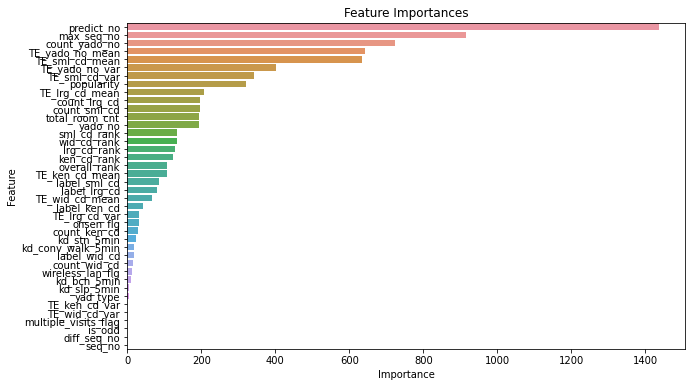

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [14]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [15]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.042438
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.004517
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.016463
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.031178
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.036239


In [16]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.042438
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.004517
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.016463
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.031178
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.036239
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-0.051655
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-0.067563
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-0.060043
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-0.069793


In [17]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.042438
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.004517
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.016463
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.031178
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.036239
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-0.051655
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-0.067563
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-0.060043
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-0.069793


In [18]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/lgbRanker_ver12_oof_pred.csv', index=False)

In [19]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.042438
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.004517
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.016463
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.031178
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.036239
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-0.051655
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-0.067563
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-0.060043
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-0.069793


### CVの計算

In [20]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [21]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [22]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 5490, 12491, 1284, 4072, 254]
CPU times: user 152 ms, sys: 15 µs, total: 152 ms
Wall time: 153 ms


In [23]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:44<00:00, 6536.90it/s]


In [24]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,11882,2808,997,12846,5289,3324,9208,9207,9209
1,8253,8225,8747,3725,2570,2259,11104,1586,3564,4488
2,4863,9039,4355,6722,7509,2957,1967,13642,5238,11724
3,626,13549,755,2272,11715,7812,1341,109,13296,7872
4,96,3894,7749,902,11380,5490,12491,1284,4072,254
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,5719,3725,10955,10522,2876,13717,8677,1586
288694,8703,3940,399,4767,2900,963,513,6654,8465,5299
288695,7308,4040,12240,7820,10364,2087,4398,9558,3566,844
288696,10619,570,12500,11091,3238,7551,12829,10616,12781,11316


### 要素の集合にバグがないかを確認

In [26]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [27]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [28]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [29]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
283291


In [30]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [31]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,11882,2808,997,12846,5289,3324,9208,9207,9209
1,8253,8225,8747,3725,2570,2259,11104,1586,3564,4488
2,4863,9039,4355,6722,7509,2957,1967,13642,5238,11724
3,626,13549,755,2272,11715,7812,1341,109,13296,7872
4,96,3894,7749,902,11380,5490,12491,1284,4072,254
5,4823,10510,12544,5369,9202,9201,9207,9200,9199,1
6,7531,12774,441,2480,13240,4574,2282,7273,10442,10378
7,111,4744,9508,7681,1755,12962,12464,10544,10362,12125
8,899,13220,3644,3802,12432,4014,1227,9723,13702,2164
9,3278,10478,6592,379,9773,2806,3483,550,4303,9430


In [61]:
train_label.head(20)

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
5,00011afe25c343301ee961b3b0ce2e4d,4823
6,000125c737df1802b6e365f93c96d3c8,10378
7,0001763050a10b21062a1304fb743fd4,10362
8,000178c4d4d567d4715331dd0cdab76c,1227
9,0001e6a407a85dc50ac132a5c7016bab,175


In [32]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [33]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [34]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.43162571048320164


In [35]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [36]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [37]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,11882,2808,997,12846,5289,3324,9208,9207,9209,False
1,8253,8225,8747,3725,2570,2259,11104,1586,3564,4488,False
2,4863,9039,4355,6722,7509,2957,1967,13642,5238,11724,False
3,626,13549,755,2272,11715,7812,1341,109,13296,7872,False
4,96,3894,7749,902,11380,5490,12491,1284,4072,254,False


### 推論用の候補テーブル作成

In [38]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [39]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.04947026 -0.01468654 -0.01110261 ...  0.00579429 -0.00736787
  0.00265169]
1683604


In [40]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [41]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [42]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.049470
1,00001149e9c73985425197104712478c,4714,-0.014687
2,00001149e9c73985425197104712478c,2680,-0.011103
3,00001149e9c73985425197104712478c,4420,-0.036216
4,00001149e9c73985425197104712478c,5466,-0.036314


In [43]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.049470
1,00001149e9c73985425197104712478c,4714,-0.014687
2,00001149e9c73985425197104712478c,2680,-0.011103
3,00001149e9c73985425197104712478c,4420,-0.036216
4,00001149e9c73985425197104712478c,5466,-0.036314
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.014055
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.016981
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.005794
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.007368


In [45]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.049470
1,00001149e9c73985425197104712478c,4714,-0.014687
2,00001149e9c73985425197104712478c,2680,-0.011103
3,00001149e9c73985425197104712478c,4420,-0.036216
4,00001149e9c73985425197104712478c,5466,-0.036314
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.014055
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.016981
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.005794
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.007368


In [47]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.049470
1,00001149e9c73985425197104712478c,4714,-0.014687
2,00001149e9c73985425197104712478c,2680,-0.011103
3,00001149e9c73985425197104712478c,4420,-0.036216
4,00001149e9c73985425197104712478c,5466,-0.036314
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.014055
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.016981
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.005794
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.007368


In [48]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/lgbRanker_ver12_test_pred.csv', index=False)

In [49]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [50]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 12767, 1891, 11723, 3781, 5623, 867, 11994, 12620, 634]
CPU times: user 89.4 ms, sys: 7.88 ms, total: 97.3 ms
Wall time: 97.1 ms


In [51]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:28<00:00, 6208.46it/s]


In [52]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,9830,4420,5466,9534,6563,5785
1,8108,613,11923,7014,4066,143,6129,6555,11237,12862
2,757,9190,7710,9910,1774,410,10485,6721,13570,6730
3,12341,6991,3359,5080,1542,13521,10861,4180,10746,6489
4,10826,12029,3476,2862,3854,9623,5372,9020,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440
174696,13220,899,3644,12432,3802,4014,1227,9723,13702,2164
174697,7308,2087,12939,13719,13797,13241,11037,11796,5810,8143
174698,3002,2373,4976,10287,3100,13672,1687,2692,12281,5513


In [53]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [54]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [55]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [56]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [57]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [58]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,9830,4420,5466,9534,6563,5785,False
1,8108,613,11923,7014,4066,143,6129,6555,11237,12862,False
2,757,9190,7710,9910,1774,410,10485,6721,13570,6730,False
3,12341,6991,3359,5080,1542,13521,10861,4180,10746,6489,False
4,10826,12029,3476,2862,3854,9623,5372,9020,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440,False
174696,13220,899,3644,12432,3802,4014,1227,9723,13702,2164,False
174697,7308,2087,12939,13719,13797,13241,11037,11796,5810,8143,False
174698,3002,2373,4976,10287,3100,13672,1687,2692,12281,5513,False


In [59]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/lgbRanker_ver12.csv', index=False)